# Depth Controller

## Dynamic model based on BlueROV2 Heavy using the Fossen's Model

<img src="bluerov.png" style="width:550px;height:270px" />

## **Control Strategy**

<img src="strategy.png" style="width:600px;height:400px"/>

## **Code**

In [2]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [3]:
##Global
m = 11.5  #kg                
W = 112.8 #N
B = 114.8 #N 114.8
Zg = 0.02 #m
Ix = 0.16 #kg*m^2
Iy = 0.16 #kg*m^2
Iz = 0.16 #kg*m^2

##Added Mass
X_du = -5.5   #kg
Y_dv = -12.7  #kg
Z_dw = -14.57 #kg
K_dp = -0.12  #kg*m^2/rad
M_dq = -0.12  #kg*m^2/rad
N_dr = -0.12  #kg*m^2/rad

##Linear Damping
Xu = -4.03 #Ns/m
Yv = -6.22 #Ns/m
Zw = -5.18 #Ns/m
Kp = -0.07 #Ns/rad
Mq = -0.07 #Ns/rad
Nr = -0.07 #Ns/rad

##Quadratic Damping 
Xuu = -18.18 #Ns^2/m^2
Yvv = -21.66 #Ns^2/m^2
Zww = -36.99 #Ns^2/m^2
Kpp = -1.55  #Ns^2/rad^2
Mqq = -1.55  #Ns^2/rad^2
Nrr = -1.55  #Ns^2/rad^2

MAX_Z_FORCE = 160.0

In [4]:
class Controller:
    """PID controller."""

    def __init__(self, Kp, Ki, Kd, origin_time=None):
        if origin_time is None:
            origin_time = 0

        # Gains for each term
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.windup_guard = 0.0

        # Corrections (outputs)
        self.Cp = 0.0
        self.Ci = 0.0
        self.Cd = 0.0

        self.previous_time = origin_time
        self.sp_previous_time = origin_time
        self.previous_error = 0.0
        self.previous_setpoint = 0.0
        self.previous_altitud_error = 0.0
        self.previous_altitud = 0.0
        

    def setWindup(self, windup):
        self.windup_guard = windup
        
    def Update(self, error, current_time):
        """Update PID controller."""
        dt = current_time - self.previous_time
        if dt <= 0.0:
            return 0
        de = error - self.previous_error

        self.Cp = error
        self.Ci += error * dt
        self.Cd = de / dt
        
        ##Anti-windup
        if (self.Ci < -self.windup_guard):
            self.Ci = -self.windup_guard
        elif (self.Ci > self.windup_guard):
            self.Ci = self.windup_guard
        
        #Update previous values
        self.previous_time = current_time
        self.previous_error = error

        return (
            (self.Kp * self.Cp)    # proportional term
            + (self.Ki * self.Ci)  # integral term
            + (self.Kd * self.Cd)  # derivative term
        )
    
    def derivative_error(self, current_altitud_error, dt) :
        """ Computes the angular position error from altitude error """
        de = current_altitud_error - self.previous_altitud_error
        self.previous_altitud_error = de
        return (de/dt)
    

    def altitud_controller(self, error, current_time, x_, v_):
        
        ##position
        phi = x_[3]
        theta = x_[4]     
        ##velocity
        w = v_[2]
        
        c1 = np.cos(phi)
        c2 = np.cos(theta)
      
        control_signal = self.Update(error, current_time)
        temp = -control_signal*(m - Z_dw)
        tau_linear = temp - ((Zw + Zww*np.absolute(w))*w + (W-B)*c2*c1)
        if tau_linear > MAX_Z_FORCE:
            tau_linear = MAX_Z_FORCE
        if tau_linear < -MAX_Z_FORCE:
            tau_linear = -MAX_Z_FORCE
        
        return tau_linear

In [5]:
class Bluerov:
    """Bluerov Class"""

    def __init__(self, position, velocity, acceleration, tau):
        self.x_ = position
        self.v_ = velocity
        self.acc = acceleration
        self.tau = tau
        
        self.T = np.array([[0.707,    0.707,   -0.707,  -0.707,    0,       0,       0,       0],  
                           [-0.707,   0.707,   -0.707,   0.707,    0,       0,       0,       0], 
                           [0,        0,        0,       0,       -1,       1,       1,      -1],
                           [0.06,    -0.06,     0.06,   -0.06,    -0.218,  -0.218,   0.218,   0.218],
                           [0.06,     0.06,    -0.06,   -0.06,     0.120,  -0.120,   0.120,  -0.120],
                           [-0.1888,  0.1888,   0.1888, -0.1888,   0,       0,       0,       0      ]])
        
        T_trans = self.T.transpose()
        temp = np.dot(self.T, T_trans)
        temp = np.linalg.inv(temp)
        self.T_plus = np.dot(T_trans, temp)
        
        K = np.array([40, 40, 40, 40, 40, 40, 40, 40])
        self.K_ = np.diag(K)
        self.K_inv = np.linalg.inv(self.K_)
        
        self.model(self.x_, self.v_,  self.acc, self.tau)


    def model(self, x_, v_, acc, tau) :

        ##velocity
        u = v_[0]
        v = v_[1]
        w = v_[2]
        p = v_[3]
        q = v_[4]
        r = v_[5]

        ##position
        #x = x_(1);   y = x_(2);     z = x_(3);
        phi = x_[3]
        theta = x_[4]
        psi = x_[5]

        ##Force/Torque
        X = tau[0]
        Y = tau[1]
        Z = tau[2]
        K = tau[3]
        M = tau[4]
        N = tau[5]

        u_dot = acc[0] 
        v_dot = acc[1] 
        w_dot = acc[2]
        p_dot = acc[3]
        q_dot = acc[4]
        r_dot = acc[5]

        c1 = np.cos(phi)
        c2 = np.cos(theta)
        c3 = np.cos(psi)
        s1 = np.sin(phi)
        s2 = np.sin(theta)
        s3 = np.sin(psi)
        t2 = np.tan(theta)


        ##Resulting acceleration
        u_dot = ((Xu + Xuu*np.absolute(u))*u -(Z_dw + m)*q*w -(W-B)*s2 - m*Zg*q_dot + X)/(m-X_du)
        v_dot = ((Yv + Yvv*np.absolute(v))*v + (Z_dw + m)*p*w + X_du*u*r + (W-B)*c2*s1 + m*Zg*p_dot + Y)/(m - Y_dv)
        w_dot = ((Zw + Zww*np.absolute(w))*w - (X_du - m)*q*u + (Y_dv - m)*p*v + (W-B)*c2*c1 + Z)/(m - Z_dw)
        p_dot = ((Kp + Kpp*np.absolute(p))*p - (Y_dv - Z_dw)*w*v - (M_dq - N_dr)*r*q -(Iz - Iy)*r*q - Zg*W*c2*s1 + m*Zg*v_dot + K)/(m - Z_dw)
        q_dot = ((Mq + Mqq*np.absolute(q))*q - (Z_dw - X_du)*u*w - (N_dr - K_dp)*p*r - (Ix-Iz)*p*r - Zg*W*s2 - m*Zg*u_dot + M)/(Iy-M_dq)  #Iy-M_dq = 0.28
        r_dot = ((Nr + Nrr*np.absolute(r))*r - (X_du - Y_dv)*u*v - (K_dp - M_dq)*p*q - (Iy - Ix)*p*q + N)/(Iz - N_dr)

        acc_vec = np.array([u_dot, v_dot, w_dot, p_dot, q_dot, r_dot])
        return acc_vec
    
    def thruster_system(self, u):
        F = np.dot(self.K_, u)
        tau = np.dot(self.T, F)
        #print(tau)
        return tau
    
    
    def control_allocation(self, tau):
        temp = np.dot(self.T_plus, tau)    
        u = np.dot(self.K_inv, temp)

        return u
    
    
    def kinematics(self, v, p) :
        """ Given the current velocity and the previous position computes the p_dot """
        roll = p[3]
        pitch = p[4]
        yaw = p[5]

        rec = [np.cos(yaw)*np.cos(pitch), -np.sin(yaw)*np.cos(roll)+np.cos(yaw)*np.sin(pitch)*np.sin(roll), np.sin(yaw)*np.sin(roll)+np.cos(yaw)*np.cos(roll)*np.sin(pitch),
               np.sin(yaw)*np.cos(pitch), np.cos(yaw)*np.cos(roll)+np.sin(roll)*np.sin(pitch)*np.sin(yaw), -np.cos(yaw)*np.sin(roll)+np.sin(pitch)*np.sin(yaw)*np.cos(roll),
               -np.sin(pitch), np.cos(pitch)*np.sin(roll), np.cos(pitch)*np.cos(roll)]
        rec = np.array(rec).reshape(3,3)

        to = [1.0, np.sin(roll)*np.tan(pitch), np.cos(roll)*np.tan(pitch),
              0.0, np.cos(roll), -np.sin(roll),
              0.0, np.sin(roll)/np.cos(pitch), np.cos(roll)/np.cos(pitch)]
        to = np.array(to).reshape(3,3)

        p_dot = np.zeros(6)
        p_dot[0:3] = np.dot(rec, v[0:3])
        p_dot[3:6] = np.dot(to, v[3:6])
        return p_dot
    
        # Sensor simulation
    def position_sensing(self, p_real):
        pos_uncert_amplitude = 0.02 # 10m max error
        orient_uncert_amplitude = 0.5 # 5degr max error
        # No noise settings
        #pos_uncert_amplitude = 0.0
        #orient_uncert_amplitude = 0.0

        p_noisy = np.zeros_like(p_real)
        p_noisy[0:3] = p_real[0:3] + np.array([np.random.rand()*pos_uncert_amplitude,
                                         np.random.rand()*pos_uncert_amplitude,
                                         np.random.rand()*pos_uncert_amplitude])
        p_noisy[3:7] = p_real[3:7] + np.array([np.random.rand()*np.pi/180.0*orient_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*orient_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*orient_uncert_amplitude])
        return p_noisy

    def velocity_sensing(self, v_real):
        lin_vel_uncert_amplitude = 0.02 # 0.1 m/s max error
        ang_vel_uncert_amplitude = 0.5 # 1 deg/s max error
        # No noise settings
        #lin_vel_uncert_amplitude = 0.0
        #ang_vel_uncert_amplitude = 0.0

        v_noisy = np.zeros_like(v_real)
        v_noisy[0:3] = v_real[0:3] + np.array([np.random.rand()*lin_vel_uncert_amplitude,
                                         np.random.rand()*lin_vel_uncert_amplitude,
                                         np.random.rand()*lin_vel_uncert_amplitude])
        v_noisy[3:7] = v_real[3:7] + np.array([np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude])
        return v_noisy
    
    def integral(self, x_dot, x, t) :
        """ Computes the integral o x dt """
        x_ = (x_dot * t) + x
        #print(x_)
        return x_

 34.98 
 34.98 
 34.99 
 34.99 
 34.97 
 34.97 
 34.98 
 34.98 
 34.98 
 34.98 
 35.01 
 35.01 
 35.01 
 35.01 
 35.01 
 35.01 
 35.01 
 35.01 
 35.02 
 35.02 


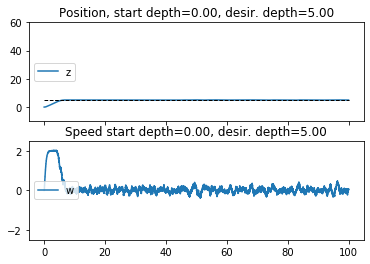

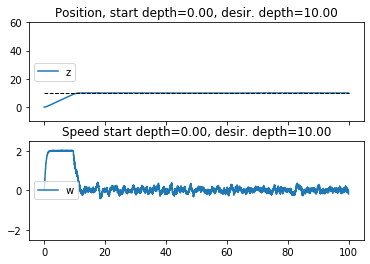

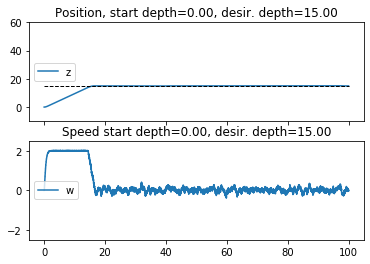

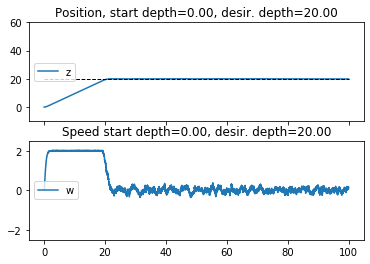

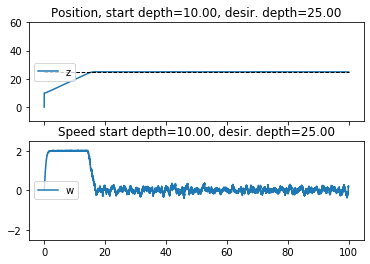

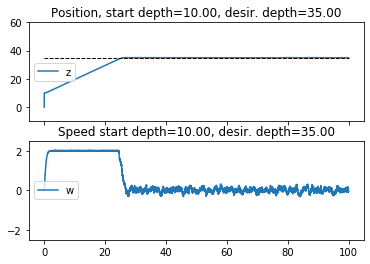

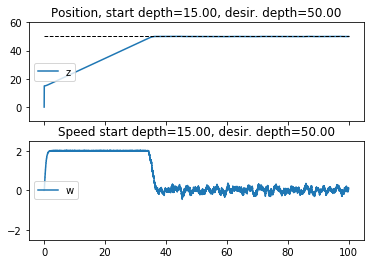

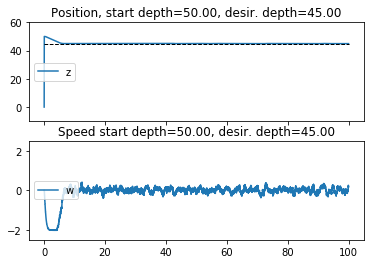

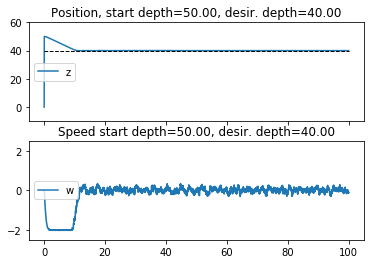

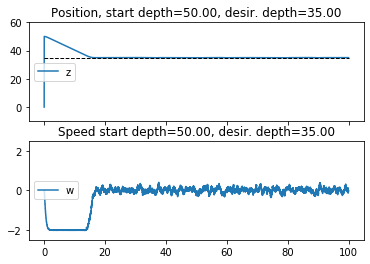

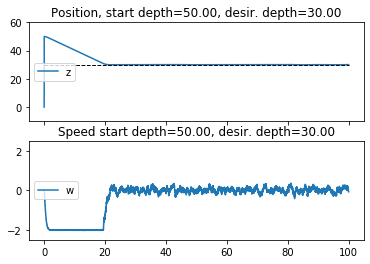

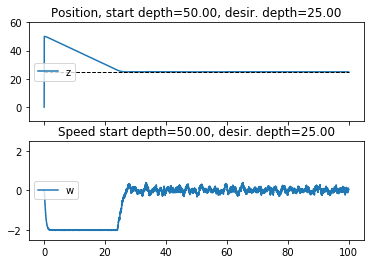

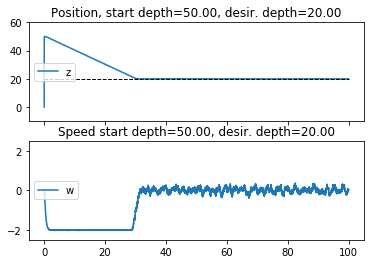

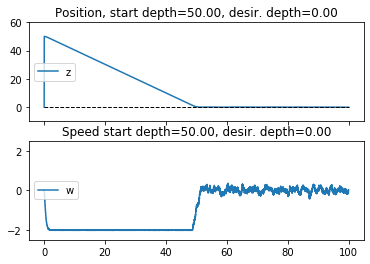

In [6]:
## The main loop of the simulation
num_actuators = 8
  
# Settings of the simulation time in seconds
period = 0.01
t_max = 100.0
t_max_ = t_max/2.0

initcond = [{'p_a':0.0,'d_a':5.0,},
           {'p_a':0.0,'d_a':10.0,},
           {'p_a':0.0,'d_a':15.0,},
           {'p_a':0.0,'d_a':20.0,},
           {'p_a':10.0,'d_a':25.0,},
           {'p_a':10.0,'d_a':35.0,},
           {'p_a':15.0,'d_a':50.0,},
           {'p_a':50.0,'d_a':45.0,},
           {'p_a':50.0,'d_a':40.0,},
           {'p_a':50.0,'d_a':35.0,},
           {'p_a':50.0,'d_a':30.0,},
           {'p_a':50.0,'d_a':25.0,},
           {'p_a':50.0,'d_a':20.0,},
           {'p_a':50.0,'d_a':0.0,},]

pltnames = []

for trial in initcond:
    
    # Input on initial conditions:
    prev_altitude = trial['p_a']
    #desired_altitud = -34
    desired_altitud = trial['d_a']
    
    # Setting initial conditions:
    #p = np.array(np.zeros(6))
    p = np.array([0.0,0.0,prev_altitude,0.0,0.0,0.0])
    v = np.array(np.zeros(6))
    acc = np.array(np.zeros(6))
    # Not used?

    time = np.arange(0.0,t_max,period)
    time2 = np.arange(0.0,t_max_,period)

    # Initialise the position/velocity storage variable to the initial values
    p_log = p
    v_log = v

    altitud_log = 0.0
    w_velocity_log = 0.0

    #Here you can change the resulting force for each degree of freedom
    tau = np.array([[0], [0], [0], [0], [0], [0]]) # Force vector
    bluerov = Bluerov(p, v, acc, tau) 
    #u = bluerov.control_allocation(tau) #This function return the thruster's control input 
    z_controller = Controller(15, 0.0, 0.1, 0)
    z_head_controller = Controller(5.0, 0.0, 5.3, 0)
    z_controller.setWindup(20)
    z_head_controller.setWindup(20)
    
    count = 0
    w_ref = 0.0
    w_error = 0.0
    altitude = prev_altitude
    w_velocity = 0.0
    p_sens = np.array(np.zeros(6))
    v_sens = np.array(np.zeros(6))
    

    for tstep in time[1:]:
        # Sensors
        #p_sens = bluerov.position_sensing(p)
        #v_sens = bluerov.velocity_sensing(v)

        #altitude = p_sens[2]
        #w_velocity = v_sens[2]
        
        count = count + 1
        if (count % 2) == 0:
            # Sensors
            p_sens = bluerov.position_sensing(p)
            v_sens = bluerov.velocity_sensing(v)

            altitude = p_sens[2]
            w_velocity = v_sens[2]
            ## External loop Cascade Controller 50Hz
            altitude_error = altitude - desired_altitud 
            w_ref = z_head_controller.Update(altitude_error, tstep)
            
            v_dot = np.squeeze(np.asarray(v_dot))
            v = bluerov.integral(v_dot, v, period)

            p_dot = bluerov.kinematics(v,p)
            p = bluerov.integral(p_dot, p, period)
      
        ## Internal loop controller (Nonlinear decoupling) 100Hz
        w_error = w_ref - w_velocity
        linear_z_tau = z_controller.altitud_controller(w_error, tstep, p_sens, v_sens)
        linear_tau = np.array([[0], [0], [linear_z_tau], [0], [0], [0]]) # Force vector

        ##This function return the thruster's control input 
        u = bluerov.control_allocation(linear_tau)

        ##Force/Torque input
        tau = bluerov.thruster_system(u)

        v_dot = bluerov.model(p, v, acc, tau)
        acc = v_dot

        #v_dot = np.squeeze(np.asarray(v_dot))
        #v = bluerov.integral(v_dot, v, period)

        #p_dot = bluerov.kinematics(v,p)
        #p = bluerov.integral(p_dot, p, period)

        if tstep >= (t_max - period*10):
            if desired_altitud == 35.0:
                print("% 6.2f " % (altitude))

        # Saving the simulated values for later plotting
        altitud_log = np.vstack((altitud_log, altitude))
        w_velocity_log = np.vstack((w_velocity_log, w_velocity))
        

    # The plotting
    fig, axs = plt.subplots(2,1, sharex='col')
    axs[0].plot(time, altitud_log)
    axs[0].plot([time[0], time[-1]], [trial['d_a'], trial['d_a']], color='k', linestyle='--', linewidth=1)
    axs[0].set_ylim([-10.0,60.0])
    axs[0].set_title('Position, start depth=%.2f, desir. depth=%.2f'%(trial['p_a'],trial['d_a']))
    axs[0].legend(['z',], loc="center left")

    axs[1].plot(time, w_velocity_log)
    axs[1].set_ylim([-2.5,2.5])
    axs[1].set_title('Speed start depth=%.2f, desir. depth=%.2f'%(trial['p_a'],trial['d_a']))
    axs[1].legend(['w'], loc="center left")
    plt.savefig('plot-p_a=%f,d_a=%f.png'%(trial['p_a'],trial['d_a']), dpi=150)

    pltnames.append('plot-p_a=%f,d_a=%f.png'%(trial['p_a'],trial['d_a']))
    